# Gridworld with Policy Iteration

In [1]:
import numpy as np
import random

# display output
from random import uniform
import time
from IPython.display import display, clear_output

In [2]:
discount_factor = 0.8 # small prefer immediate reward, large prefer future reward
actions = [[-1, 0], [0, 1], [1, 0], [0, -1]] #up, right, down, left = (clockwise from up) 
action_count = len(actions) # total number of actions
gridSize = 5 # create a square grid of gridSize by gridSize
state_count = gridSize*gridSize # total number of states

In [3]:
# initialize a policy: create an array of dimension (number of states by number of actions)
# for equal probability amongst all actions, divide everything by the number of actions
policy = np.ones([state_count, action_count]) / action_count

# policy at state 0 = [0, 0]
# returns a probability for each action given state
policy[0]

array([0.25, 0.25, 0.25, 0.25])

In [4]:
policy[0][1]

0.25

In [5]:
class Gridworld():
    def __init__(self, gridSize):
        self.valueMap = np.zeros((gridSize, gridSize))
        self.states = [[i, j] for i in range(gridSize) for j in range(gridSize)]
        self.size = gridSize
        self.new_pos = [0, 0] # initialize new position for p_transition
        self.pos_check = [0, 0] # a copy of new position
        self.transition_prob = 1 # deterministic
    
    def initial_state(self):
        # randomly generate an initial state
        i = random.randint(0, len(self.states)-1)
        rand_state = self.states[i]
        return rand_state
    
    def possible_states(self):
        # return the possible states
        return self.states
    
    def reward(self, current_pos, action):
        # return the reward        
        
        # take action in current pos
        self.new_pos = np.array(current_pos) + np.array(action)

        # normally, reward = 0
        reward = 0

        # if new pos results in off the grid, return reward -1
        if -1 in self.new_pos or self.size in self.new_pos:
            reward = -1
        # if in state A, transition to state A'
        if current_pos == [0, 1]:
            reward = 10
        # if in state B, transition to state B'
        if current_pos == [0, 3]:
            reward = 5
        return reward
    
    # def transition_probability(self, current_pos, new_pos):
        # a function that returns the entries of the transition probability matrix?
        # eg. input current state, new state, output = 0.25...0.5...1 ... etc. ?
    
    def p_transition(self, current_pos, action):
        # return the transition probability
        # get next position: state: [0, 0], action: [0, 1], new_state = [0, 1]
        self.new_pos = np.array(current_pos) + np.array(action)
        self.pos_check = self.new_pos # make a copy of new pos before being overwritten below

        # if taking an action crosses the border = agent stays in same position
        if -1 in self.new_pos or self.size in self.new_pos: 
            self.new_pos = current_pos
            
        # if in state A, transition to state A'
        if current_pos == [0, 1]:
            self.new_pos = [4, 1]
            
        # if in state B, transition to state B'
        if current_pos == [0, 3]:
            self.new_pos = [2, 3]
        return self.new_pos

In [6]:
# create a grid object
grid = Gridworld(5)
grid.valueMap

array([[0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.]])

In [7]:
# # return a random initial state
# grid.initial_state()

In [8]:
# # return all possible states
# grid.possible_states()

# Policy Iteration 

In [9]:
iterations = 0
theta = 0.000001
delta_list = []

In [10]:
# function to calculate action value with the current policy

def calculate_action_value(state, value):
    A = np.zeros(action_count)
    
    # perform 4 actions per state and add the rewards (value)
    for action_number, action in enumerate(actions):
            
        # get next position and reward
        new_position = grid.p_transition(state, action)
        reward = grid.reward(state, action)
        
        # get next position and reward
        new_position = grid.p_transition(state, action)
        reward = grid.reward(state, action)

        # calculate value of action: transition_prob*[r + gamma * value(s')]
        A[action_number] += grid.transition_prob*(reward+(discount_factor*value[new_position[0], new_position[1]]))
    
    return A

In [11]:
# policy iteration

while True:
    
    # POLICY EVALUATION ####################################
        # iterate through all 25 states. At each state, iterate through all 4 actions
        # to calculate the value of each action.
        # Replace the value map with the calculated value.
    while True:
        delta = 0
        iterations+=1
        valueMap_copy = np.copy(grid.valueMap)

        # start with the first state in the state list
        for state_number, state in enumerate(grid.states):
            value = 0

            # perform 4 actions per state and add the rewards (value)
            for action_number, action in enumerate(actions):

                # get next position and reward
                new_position = grid.p_transition(state, action)
                reward = grid.reward(state, action)

                # calculate value: policy*transition_prob*[r + gamma * value(s')]
                value += policy[state_number][action_number]*grid.transition_prob*(reward+(discount_factor*grid.valueMap[new_position[0], new_position[1]]))          

            # replace the value in valueMap with the value
            valueMap_copy[state[0], state[1]] = value

            # calculate delta
            delta = max(delta, np.abs(value - grid.valueMap[state[0], state[1]]))       
            clear_output(wait=True)
            display('delta: ' + str(delta) + ' iterations: ' + str(iterations))

            # save data for plot
            delta_list.append(delta)

        # overwrite the original value map (update valuemap after one complete iteration of every state)
        grid.valueMap = valueMap_copy

        # stop when change in value function falls below a given threshold
        if delta < theta:
            break
    
    # POLICY IMPROVEMENT #######################################
        # iterate through every state and choose the best action with the current policy
        # calculate the action values of every state
        # take the best action and compare whether the best action is the same as the chosen one
        # update the policy with the best action
    
    # initate policy_true as stable
    policy_stable = True

    # iterate over every state
    for state_number, state in enumerate(grid.states):

        # choose the best action with the current policy
        choose_action = np.argmax(policy[state_number])

        # calculate the action values for each state using the current value function
        # eg. action_values = [#, #, #, #] = a value for each of the 4 actions
        action_values = calculate_action_value(state, grid.valueMap)

        # using the calculated action values, find the best action
        best_action = np.argmax(action_values)

        # if the chosen action is different than the calculated best action
        # then the current policy is not stable
        if choose_action != best_action:
            policy_stable = False

        # update the current policy with the new best action
        policy[state_number] = np.eye(action_count)[best_action]

    # if the policy is stable (eg. chosen action is the same as best action)
    # then we can exit
    # however, if it is not, then we need to perform policy evaluation and improvement again
    if policy_stable:
        break

'delta: 6.516798087830011e-07 iterations: 116'

In [12]:
# print value map to 4 decimal places
np.set_printoptions(precision=4)
grid.valueMap

array([[11.8991, 14.8739, 11.8991, 10.2459,  8.1967],
       [ 9.5193, 11.8991,  9.5193,  8.1967,  6.5574],
       [ 7.6154,  9.5193,  7.6154,  6.5574,  5.2459],
       [ 6.0923,  7.6154,  6.0923,  5.2459,  4.1967],
       [ 4.8739,  6.0923,  4.8739,  4.1967,  3.3574]])

## Plot Delta

In [13]:
import matplotlib.pyplot as plt

In [14]:
# get every 25th value
delta_list2 = delta_list[0::state_count]

Text(0, 0.5, 'Max Delta')

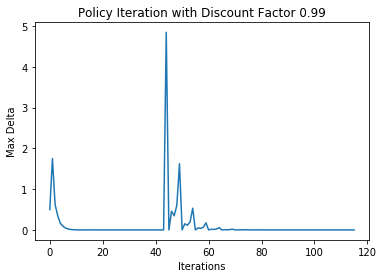

In [15]:
# plot iteration vs delta
plt.plot(range(iterations), delta_list2)
plt.title('Policy Iteration with Discount Factor 0.99')
plt.xlabel('Iterations')
plt.ylabel('Max Delta')

# Print Policy Table 

In [16]:
# import pandas library
import pandas as pd
# define column and index
columns=range(grid.size)
index = range(grid.size)
# define dataframe to represent policy table
policy_table = pd.DataFrame(index = index, columns=columns)

In [17]:
# iterate through policy to make a table that represents action number
# as action name (eg. left, right, up, down)
for state in range(len(policy)):
    for action in range(policy.shape[1]):
        if policy[state][action] == 1:
            
            # calculate the row and column coordinate of the current state number
            row = int(state/grid.size)
            column = round((state/grid.size - int(state/grid.size))*grid.size)

            # get action name
            if action == 0:
                action_name = 'up'
            elif action == 1:
                action_name = 'right'
            elif action == 2:
                action_name = 'down'
            else:
                action_name = 'left'
            
            # assign action name
            policy_table.loc[row][column] = action_name
            

In [18]:
# print policy table
policy_table

,0,1,2,3,4
0,right,up,left,up,left
1,up,up,up,up,up
2,up,up,up,up,up
3,up,up,up,up,up
4,up,up,up,up,up


# Separate Code 

## Policy Evaluation

In [19]:
# # policy evaluation
#     # iterate through all 25 states. At each state, iterate through all 4 actions
#     # to calculate the value of each action.
#     # Replace the value map with the calculated value.

# theta = 0.001
# iterations = 0

# while True:
    
#     delta = 0
#     iterations+=1
#     valueMap_copy = np.copy(grid.valueMap)
    
#     # start with the first state in the state list
#     for state_number, state in enumerate(grid.states):
#         value = 0
        
#         # perform 4 actions per state and add the rewards (value)
#         for action_number, action in enumerate(actions):
            
#             # get next position and reward
#             new_position = grid.p_transition(state, action)
#             reward = grid.reward(state, action)
            
#             # calculate value: policy*transition_prob*[r + gamma * value(s')]
#             value += policy[state_number][action_number]*grid.transition_prob*(reward+(discount_factor*grid.valueMap[new_position[0], new_position[1]]))          
            
#         # replace the value in valueMap with the value
#         valueMap_copy[state[0], state[1]] = value
        
#         # calculate delta
#         delta = max(delta, np.abs(value - grid.valueMap[state[0], state[1]]))       
#         clear_output(wait=True)
#         display('delta: ' + str(delta) + ' iterations: ' + str(iterations))
        
#         # overwrite the original value map
#         grid.valueMap = valueMap_copy

#     # stop when change in value function falls below a given threshold
#     if delta < theta:
#         break

In [20]:
# # print value map to 4 decimal places
# np.set_printoptions(precision=4)
# grid.valueMap

## Policy Improvement 

In [21]:
# # policy improvement

# while True:
    
#     policy_stable = True
    
#     for state_number, state in enumerate(grid.states):

#          # The best action we would take under the current policy
#         chosen_a = np.argmax(policy[state_number])

#          # eg. action_values = [#, #, #, #] = a value for each of the 4 actions
#         action_values = calculate_action_value(state, grid.valueMap)

#          # take the action with the highest value
#         best_a = np.argmax(action_values)

#          # Greedily update the policy
#         if chosen_a != best_a:
#             policy_stable = False

#          # update the policy with the best action
#         policy[state_number] = np.eye(action_count)[best_a]

#      # If the policy is stable we've found an optimal policy. Return it
#     if policy_stable:
#         break

In [22]:
# policy